In [1]:
from test import test_loop

from data_loading import get_image_data_loader
from models import *
from train import training_loop
from utils import accuracy

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

### Params

In [13]:
batch_size = 128
weight_decay = 0
learning_rate = 1e-1
momentum = 0.9
dataset_name = "mnist"
dataset_to_n_classes = {
    "mnist": 10,
    "cifar10": 10,
    "fmnist": 10,
}
exp_name = "mlp-mnist"
use_cuda = False
device = "gpu" if torch.cuda.is_available() and use_cuda else "cpu"
device

'cpu'

### Data loading

In [4]:
train_data, eval_data = get_image_data_loader(
    dataset_name,
    train=True,
    val_share=0.1,
    shuffle=True,
    batch_size=batch_size,
    single_batch=False,
)

Dataset lengths: train-54000, val-6000


In [5]:
(a, b) = next(iter(train_data))
print(a.shape, b.shape)
input_dim = np.prod(a.shape[1:])
output_dim = dataset_to_n_classes[dataset_name]

torch.Size([128, 1, 28, 28]) torch.Size([128])


In [6]:
n_hidden = 5
hidden_size = 256
mlp_dims = [input_dim] + [hidden_size for _ in range(n_hidden)] + [output_dim]
mlp = MLP(mlp_dims)

In [7]:
# ImageNet version
# resnet_imagenet = Resnet(
# img_channels=3,
# n_classes=10,
# extra_blocks_per_layer=[1, 3, 5, 2,],
# resnet_channels=[64, 128, 256, 512],
# stem_channels=64,
# stem_downsample=True,
# )
# Cifar10 version
# resnet_cifar = Resnet(
#     img_channels=3,
#     n_classes=10,
#     extra_blocks_per_layer=[5, 5, 5],
#     resnet_channels=[16, 32, 64],
#     stem_channels=16,
#     stem_downsample=False,
# )
# summary(resnet_cifar, (3, 32, 32))
baby_resnet = Resnet(
    img_channels=3,
    n_classes=10,
    extra_blocks_per_layer=[1, 1, 1],
    resnet_channels=[16, 32, 64],
    stem_channels=16,
    stem_downsample=False,
)

In [9]:
# [(name, param) for name, param in baby_resnet.named_parameters() if "expand" in name]

### Optimizer and model selection

In [14]:
model = baby_resnet
model = model.to(device)
other_params = {"lr":learning_rate, "momentum":momentum, "nesterov": True}
if isinstance(model, Resnet):
    no_decay, decay = model.get_params()
    no_decay = dict({"params": no_decay}, **other_params)
    decay = dict({"params": decay}, **other_params, weight_decay=weight_decay)
    optimizer = optim.SGD([decay, no_decay])
else:
    optimizer = optim.SGD(dict({"params": model.parameters()}, **other_params))
scheduler = optim.lr_scheduler.MultiStepLR(
    optimizer, milestones=[32000, 48000,], gamma=0.1,
)

In [31]:
dir(optimizer)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_step_count',
 'add_param_group',
 'defaults',
 'load_state_dict',
 'param_groups',
 'state',
 'state_dict',
 'step',
 'zero_grad']

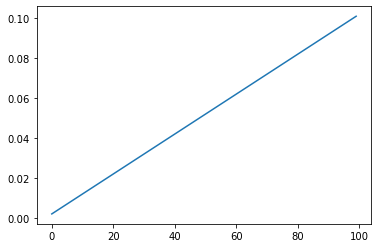

In [49]:
cosine = True
import matplotlib.pyplot as plt



target = 5
max_epoch = 100
warm_scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: (epoch +1)/ max_epoch) 
steps = list(range(100))
lrs = []
for _ in steps:
    base_scheduler.step()
    warm_scheduler.step()
    # lrs.append(base_scheduler.get_last_lr()[0])
    lrs.append(warm_scheduler.get_last_lr()[0])

plt.plot(steps, lrs)

### Training

In [16]:
n_epochs = 120
epochs_per_decay = 30
warm_epochs = 5
warm_up = True
cosine = False
if warm_up:
    warm_scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: (epoch + 1)/warm_epochs)
    training_loop(
        name=exp_name,
        model=model,
        opt=optimizer,
        scheduler=warm_scheduler,
        train_loader=train_data,
        eval_loader=eval_data,
        loss_fn=F.cross_entropy,
        metric_fn=accuracy,
        n_epochs=n_epochs,
        device=device,
        print_every=100,
        write_every=100,
        check_every=100,
    )
if not cosine:
    base_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=epochs_per_decay, gamma=0.1)
else:
    base_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs, 0)
training_loop(
    name=exp_name,
    model=model,
    opt=optimizer,
    scheduler=base_scheduler,
    train_loader=train_data,
    eval_loader=eval_data,
    loss_fn=F.cross_entropy,
    metric_fn=accuracy,
    n_epochs=n_epochs,
    device=device,
    print_every=100,
    write_every=100,
    check_every=100,
)

Step: 100 | Training Loss: 1.78911
Step: 100 | Training Metric: 0.28906
Step: 200 | Training Loss: 0.61613
Step: 200 | Training Metric: 0.78906
Step: 300 | Training Loss: 0.36819
Step: 300 | Training Metric: 0.89844
Step: 400 | Training Loss: 0.33749
Step: 400 | Training Metric: 0.90625
Step: 500 | Training Loss: 0.21975
Step: 500 | Training Metric: 0.95312
Step: 600 | Training Loss: 0.12535
Step: 600 | Training Metric: 0.95312
Step: 700 | Training Loss: 0.22960
Step: 700 | Training Metric: 0.93750
Step: 800 | Training Loss: 0.07459
Step: 800 | Training Metric: 0.97656
Step: 900 | Training Loss: 0.05047
Step: 900 | Training Metric: 0.97656
Step: 1000 | Training Loss: 0.13690
Step: 1000 | Training Metric: 0.96875
Step: 1100 | Training Loss: 0.03915
Step: 1100 | Training Metric: 0.98438
Step: 1200 | Training Loss: 0.11316
Step: 1200 | Training Metric: 0.96875
Step: 100 | Validation Loss: 0.12783
Step: 100 | Validation Metric: 0.96094
Step: 1300 | Training Loss: 0.06092
Step: 1300 | Train

KeyboardInterrupt: 

### Load from checkpoint

In [17]:
loaded = torch.load(
    os.path.join(os.path.join("data", "checkpoints"), "mlp-mnist-2900.pt"),
    map_location=device,
)
model.load_state_dict(loaded["model_state"])

<All keys matched successfully>

### Load test data

In [20]:
test_loader, should_be_none = get_image_data_loader(
    dataset_name,
    train=False,
    val_share=0.1,
    shuffle=True,
    batch_size=10,
    single_batch=False,
)
assert should_be_none is None

Dataset lengths: train-10000, val-0


### Evaluated the loaded model

Testing completed, Metric: 0.97230, Loss: 0.10392
Grid generated with labels: [7 3 1 5 0 6 2 0 3 3]
Corresponding predictions: [7 3 1 5 0 6 3 0 3 3]


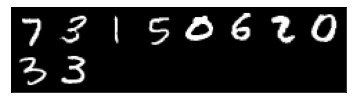

In [21]:
test_loop(
    test_loader=test_loader,
    model=model,
    device=device,
    metric_fn=accuracy,
    plot=True,
    loss_fn=F.cross_entropy,
)